In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os.path

In [2]:
image_dir = Path("E:\\DATASET\\archive (4)\\Fish_Dataset\\Fish_Dataset")
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name = 'Filepath').astype(str)
labels = pd.Series(labels, name = 'Label')

In [3]:
image_df = pd.concat([filepaths, labels], axis = 1)
image_df

,Filepath,Label
0,E:\DATASET\archive (4)\Fish_Dataset\Fish_Datas...,Black Sea Sprat
1,E:\DATASET\archive (4)\Fish_Dataset\Fish_Datas...,Black Sea Sprat
2,E:\DATASET\archive (4)\Fish_Dataset\Fish_Datas...,Black Sea Sprat
3,E:\DATASET\archive (4)\Fish_Dataset\Fish_Datas...,Black Sea Sprat
4,E:\DATASET\archive (4)\Fish_Dataset\Fish_Datas...,Black Sea Sprat
...,...,...
17995,E:\DATASET\archive (4)\Fish_Dataset\Fish_Datas...,Trout GT
17996,E:\DATASET\archive (4)\Fish_Dataset\Fish_Datas...,Trout GT
17997,E:\DATASET\archive (4)\Fish_Dataset\Fish_Datas...,Trout GT
17998,E:\DATASET\archive (4)\Fish_Dataset\Fish_Datas...,Trout GT


In [4]:
image_df.shape

(18000, 2)

In [5]:
image_df['Label'] = image_df['Label'].apply(lambda x: np.NaN if x[-2:] == 'GT' else x)
image_df = image_df.dropna(axis=0)

In [6]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 0 to 16999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  9000 non-null   object
 1   Label     9000 non-null   object
dtypes: object(2)
memory usage: 210.9+ KB


In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(image_df, test_size=0.3,random_state=30)

In [8]:
print("Shape of training data", x_train.shape)
print("Shape of testing data", x_test.shape)

Shape of training data (6300, 2)
Shape of testing data (2700, 2)


In [9]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import preprocess_input

In [10]:
# Train and test split with imagedatagenerator in keras
trainGen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    validation_split=0.3)


testGen =ImageDataGenerator(
    preprocessing_function= preprocess_input)

In [11]:
train_img = trainGen.flow_from_dataframe(
    dataframe=x_train, 
    x_col='Filepath', 
    y_col='Label', 
    target_size=(200,200), 
    color_mode='rgb', 
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

val_img = trainGen.flow_from_dataframe(
    dataframe=x_train, 
    x_col='Filepath', 
    y_col='Label', 
    target_size=(200,200), 
    color_mode='rgb', 
    class_mode='categorical',
    subset='validation',
    batch_size=32,
    shuffle=False
)

test_img = testGen.flow_from_dataframe(
    dataframe=x_test, 
    x_col='Filepath', 
    y_col='Label', 
    target_size=(200,200), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=32,
    shuffle=False
)

Found 6300 validated image filenames belonging to 9 classes.
Found 1890 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.


In [13]:
train_img[0][0].shape

(32, 200, 200, 3)

In [14]:

input_shape = (200, 200, 3)

In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [16]:
model = Sequential([
    Conv2D(64, (3,3), activation = 'relu', input_shape = input_shape),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
           
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
           
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
           
    Dense(128, activation='relu'),
    Dropout(0.2),
           
    Dense(9, activation='softmax')
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

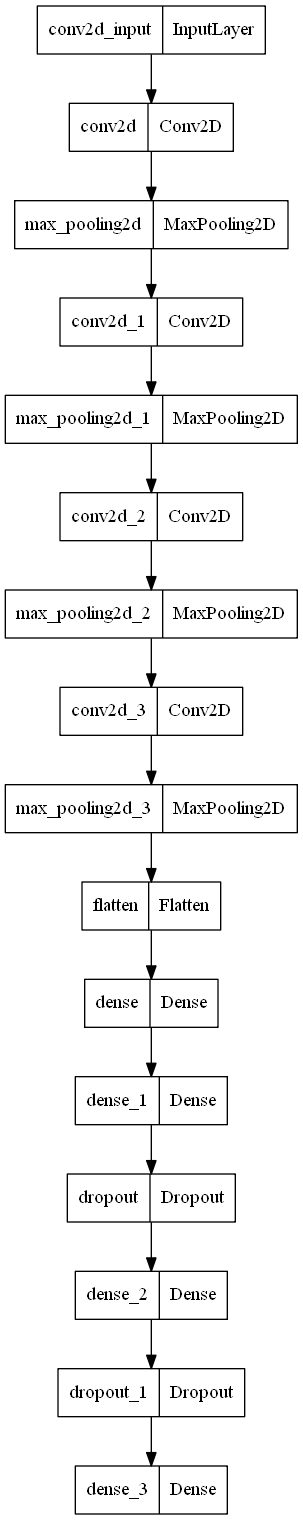

In [17]:
from keras.utils import plot_model

plot_model(model)

In [18]:
for i in range(len(model.layers)):
	# check for convolutional layer
	if 'conv' not in model.layers[i].name:
		continue
	# get filter weights
	filters, biases = model.layers[i].get_weights()
	print("layer number",i,model.layers[i].name, filters.shape)

layer number 0 conv2d (3, 3, 3, 64)
layer number 2 conv2d_1 (3, 3, 64, 64)
layer number 4 conv2d_2 (3, 3, 64, 32)
layer number 6 conv2d_3 (3, 3, 32, 32)


In [19]:
# retrieve weights from the second hidden layer
filters , bias = model.layers[0].get_weights()

In [20]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

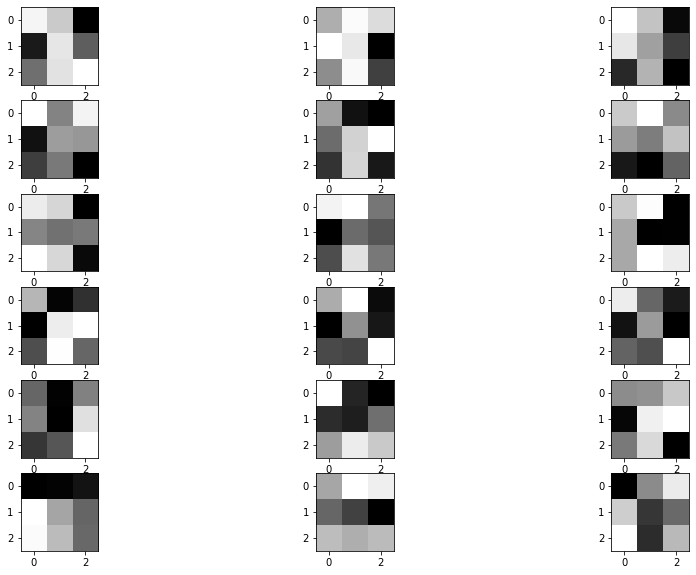

In [23]:

n_filters =6
ix=1
fig = plt.figure(figsize=(15,10))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
plt.show()

In [24]:
from tensorflow.keras import Model
model = Model(inputs=model.inputs , outputs=model.layers[1].output)

In [30]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
img = load_img("C:\\Users\\soumi\\OneDrive\\Desktop\\PROJECT_NOTES\\00016.png" , target_size=(200,200))

# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = tf.expand_dims(img, axis=0)

img = preprocess_input(img)

1/1 [==============================] - 3s 3s/step


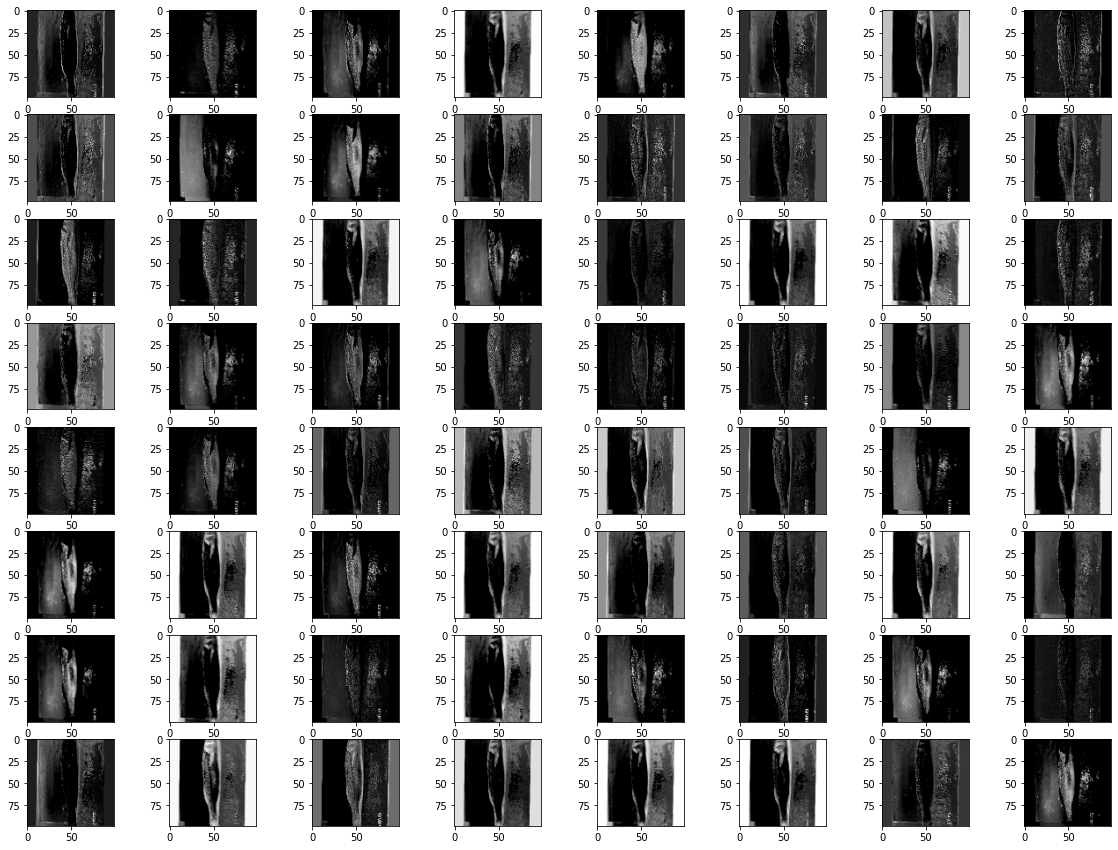

In [32]:
#calculating features_map
features = model.predict(img)

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.show()

In [34]:
model1 = Sequential([
    Conv2D(64, (3,3), activation = 'relu', input_shape = input_shape),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
           
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
           
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
           
    Dense(128, activation='relu'),
    Dropout(0.2),
           
    Dense(9, activation='softmax')
    
])

In [35]:
layer_index = [0, 2, 4, 6]
outputs = [model1.layers[i].output for i in layer_index]

model2 = Model( inputs= model1.inputs, outputs = outputs)

1/1 [==============================] - 0s 144ms/step


IndexError: index 32 is out of bounds for axis 3 with size 32

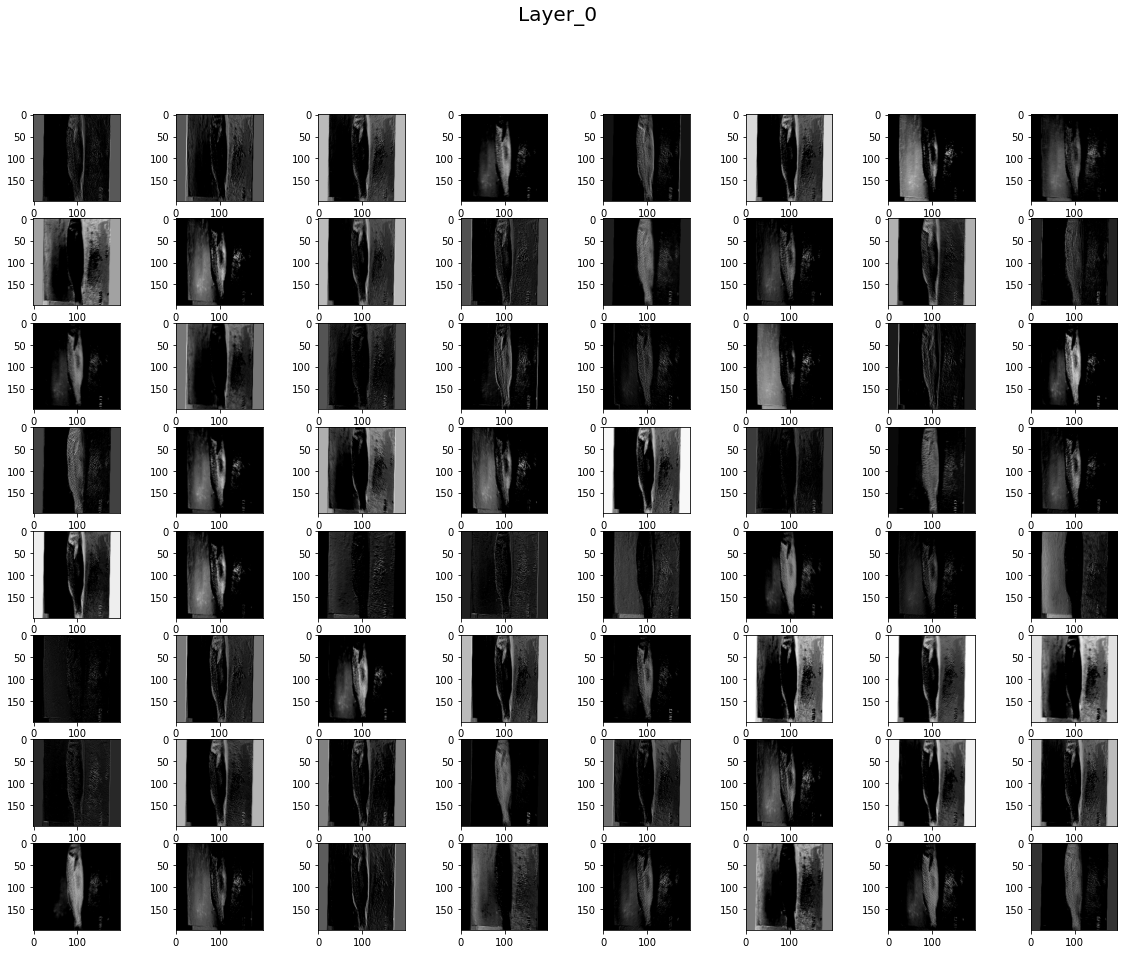

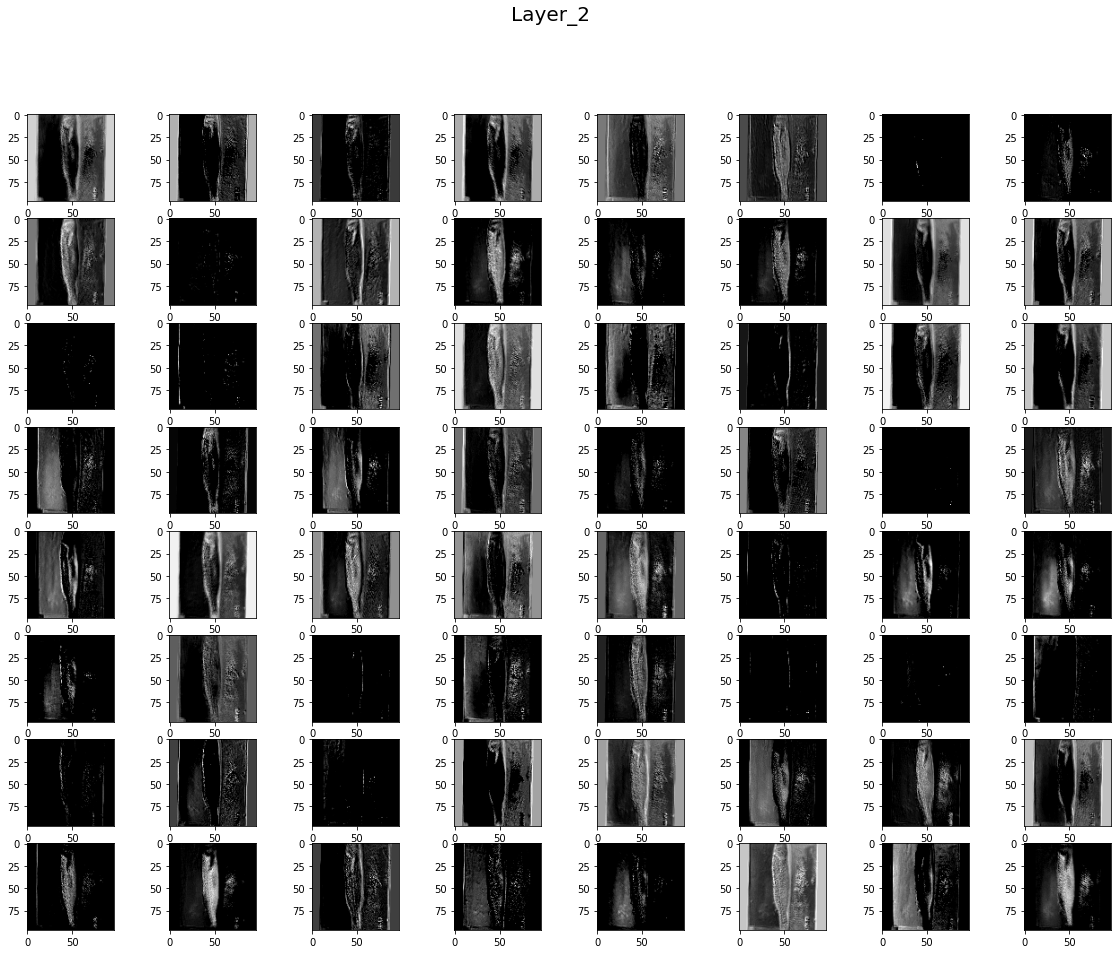

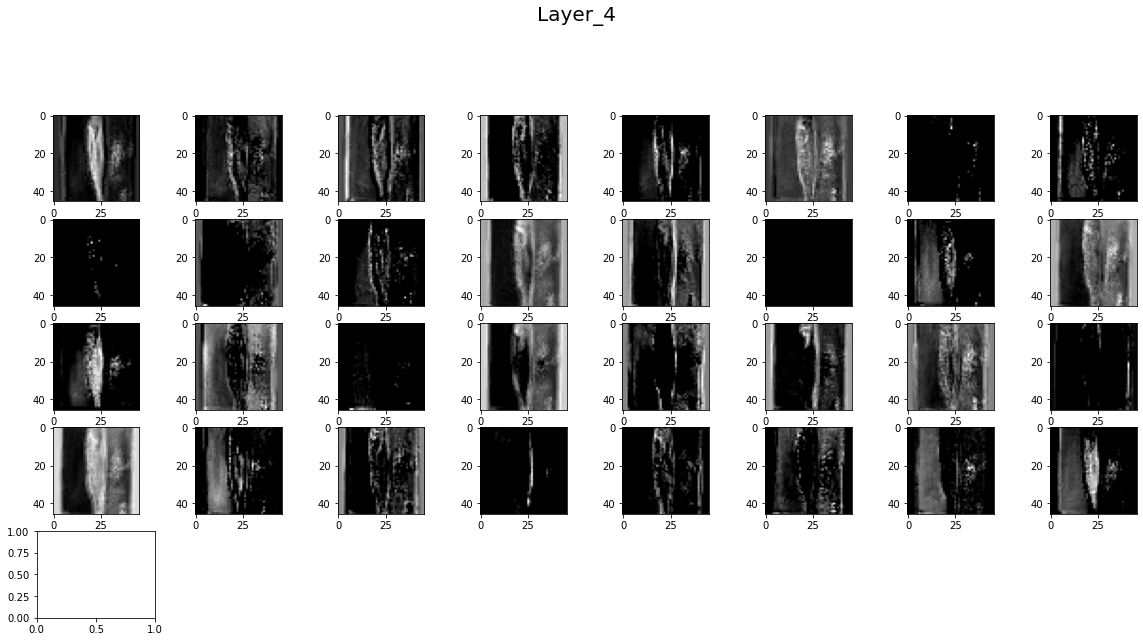

In [36]:
feature_map = model2.predict(img)

for i,fmap in zip(layer_index,feature_map):
    fig = plt.figure(figsize=(20,15))
    fig.suptitle("Layer_{}".format(i) , fontsize=20)
    for i in range(1,features.shape[3]+1):

        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i-1] , cmap='gray')
    
pyplot.show()